In [1]:
# pip install matplotlib matplotlib-venn numpy

In [3]:
import json
import os
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2, venn3_circles, venn2_circles
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.textpath import TextPath
from matplotlib.patches import PathPatch
from matplotlib.transforms import Affine2D
from matplotlib.patches import FancyArrowPatch


### Content of the DBsearch.json compiled file

### Structure of `results`

`results` is a list where each element is a list of three components: `[query_pred, ground_truth, reference_rankings]`.

1. **query_pred**: The query prediction is our test set, and it is also used as the query spectrum for the MS-Library search. It includes:
   - `dbid`: The database ID
   - `qsmi`: The compound's SMILES string
   - `qspectrum`: Its corresponding spectrum
   - `pred_rae`: The set of predicted RAEs

   Example: `testid, qsmi, qspectrum, pred_rae = query_pred`

2. **ground_truth**: Represents the ground truth molecule. It includes:
   - `gt_id`: Ground Truth ID
   - `gt_smiles`: SMILES string of the ground truth
   - `gt_spectrum`: Spectrum of the ground truth
   - `gt_rae`: RAEs of the ground truth
   - `gt_cos`: Cosine similarity metric
   - `gt_smi_tc`: SMILES Tanimoto coefficient
   - `gt_rae_tc`: RAE-based Tanimoto coefficient

   Example: `gt_id, gt_smiles, gt_spectrum, gt_rae, gt_cos, gt_smi_tc, gt_rae_tc = ground_truth`

3. **reference_rankings**: The top molecules from the MS search based on cosine similarity. It includes:
   - `ref_id`: Reference ID
   - `ref_smiles`: SMILES string of the reference
   - `ref_spectrum`: Spectrum of the reference
   - `ref_rae`: RAEs of the reference
   - `venn`: Venn diagram data
   - `cos`: Cosine similarity metric
   - `smi_tc`: SMILES Tanimoto coefficient
   - `rae_tc`: RAE-based Tanimoto coefficient

   Example: `ref_id, ref_smiles, ref_spectrum, ref_rae, venn, cos, smi_tc, rae_tc = topk`

### Define Color Mappings and Regions

In [4]:
VENN3_REGIONS = [
    ('100', r'$P ∖ (GT ∪ R)$', 'Pred only', '#a6cee3'),
    ('010', r'$GT ∖ (P ∪ R)$', 'GT only', '#ff9999'),
    ('001', r'$R ∖ (P ∪ GT)$', 'Lib only', '#fdbf6f'),
    ('110', r'$P ∩ GT ∖ R$', 'Pred & GT', '#cab2d6'),
    ('101', r'$P ∩ R ∖ GT$', 'Pred & Lib', '#ffff99'),
    ('011', r'$GT ∩ R ∖ P$', 'GT & Lib', '#fb9a99'),
    ('111', r'$P ∩ GT ∩ R$', 'All three', '#8dd3c7'),
]

VENN2_REGIONS = [
    ('10', r'$P ∖ R$', 'Pred only', '#a6cee3'),
    ('01', r'$R ∖ P$', 'Lib only', '#fdbf6f'),
    ('11', r'$P ∩ R$', 'Pred & Lib', '#b2df8a'),
]


### Utility Functions to Compute Set Contents

In [5]:
def get_venn3_region_contents(pred, gt, lib):
    sets = list(map(set, [pred, gt, lib]))
    return {
        '100': sets[0] - (sets[1] | sets[2]),
        '010': sets[1] - (sets[0] | sets[2]),
        '001': sets[2] - (sets[0] | sets[1]),
        '110': (sets[0] & sets[1]) - sets[2],
        '101': (sets[0] & sets[2]) - sets[1],
        '011': (sets[1] & sets[2]) - sets[0],
        '111': sets[0] & sets[1] & sets[2],
    }

def get_venn2_region_contents(pred, lib):
    sets = list(map(set, [pred, lib]))
    return {
        '10': sets[0] - sets[1],
        '01': sets[1] - sets[0],
        '11': sets[0] & sets[1],
    }

def remap_rae(rae_list, mapping_dict):
    return [mapping_dict.get(rae, rae) for rae in set(rae_list)]


### Label Drawing Helpers (Arrows and Arcs)

In [6]:
def draw_label_with_arrow(ax, center, radius, text, color, angle_deg, label_offset=1.8, arrow_pad=0.15, fontsize=14):
    angle_rad = np.deg2rad(angle_deg)
    x_label = center[0] + label_offset * radius * np.cos(angle_rad)
    y_label = center[1] + label_offset * radius * np.sin(angle_rad)
    ax.text(x_label, y_label, text, color='black', fontsize=fontsize, ha='center', va='center', fontweight='bold', zorder=10)
    arrow_start_offset = label_offset - arrow_pad
    x_arrow_start = center[0] + arrow_start_offset * radius * np.cos(angle_rad)
    y_arrow_start = center[1] + arrow_start_offset * radius * np.sin(angle_rad)
    x_circle = center[0] + radius * np.cos(angle_rad)
    y_circle = center[1] + radius * np.sin(angle_rad)
    arrow = FancyArrowPatch(
        (x_arrow_start, y_arrow_start), (x_circle, y_circle),
        connectionstyle="arc3,rad=0.25",
        arrowstyle='->',
        color=color,
        linewidth=2.5,
        mutation_scale=18,
        zorder=9
    )
    ax.add_patch(arrow)


### Plotting Function for Venn Diagram and Table

In [7]:
def plot_venn_with_table(pred_rae, ref_rae, gt_rae=None, show_gt=True):
    import matplotlib.gridspec as gridspec
    fig = plt.figure(figsize=(14, 7))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    
    if show_gt and gt_rae is not None:
        sets = list(map(set, [pred_rae, gt_rae, ref_rae]))
        v = venn3(subsets=sets, set_labels=(None, None, None), ax=ax0)
        circles = venn3_circles(subsets=sets, ax=ax0)
        region_contents = get_venn3_region_contents(pred_rae, gt_rae, ref_rae)
        set_colors = [VENN3_REGIONS[0][3], VENN3_REGIONS[1][3], VENN3_REGIONS[2][3]]

        for i, circle in enumerate(circles):
            style = 'dashed'
            circle.set_linestyle(style)
            circle.set_linewidth(2.5)
            circle.set_edgecolor(set_colors[i] if i != 1 else 'black')

        for region, _, _, color in VENN3_REGIONS:
            patch = v.get_patch_by_id(region)
            if patch:
                patch.set_color('none' if region == '010' else color)
                patch.set_alpha(0 if region == '010' else 0.6)
        
        for region, _, _, _ in VENN3_REGIONS:
            label = v.get_label_by_id(region)
            items = sorted(region_contents[region])
            if label is not None:
                label.set_text('\n'.join(map(str, items)) if items else '')
                label.set_fontsize(10)

        set_names = ['Prediction', 'Ground Truth', 'Library Hit']
        set_angles = [330, 90, 210]
        for i, (name, color, angle) in enumerate(zip(set_names, set_colors, set_angles)):
            center = circles[i].center
            radius = circles[i].radius
            draw_label_with_arrow(ax0, center, radius, name, color, angle)

        table_data = [
            [expr, label, '', ', '.join(map(str, sorted(region_contents[region]))), len(region_contents[region])]
            for region, expr, label, color in VENN3_REGIONS
        ]
        colors = [color for _, _, _, color in VENN3_REGIONS]
    else:
        sets = list(map(set, [pred_rae, ref_rae]))
        v = venn2(subsets=sets, set_labels=(None, None), ax=ax0)
        circles = venn2_circles(subsets=sets, ax=ax0)
        region_contents = get_venn2_region_contents(pred_rae, ref_rae)
        set_colors = [VENN2_REGIONS[0][3], VENN2_REGIONS[1][3]]

        for i, circle in enumerate(circles):
            circle.set_linestyle('dashed')
            circle.set_linewidth(2.5)
            circle.set_edgecolor(set_colors[i])
        
        for region, _, _, color in VENN2_REGIONS:
            patch = v.get_patch_by_id(region)
            if patch:
                patch.set_color(color)
                patch.set_alpha(0.6)

        for region, _, _, _ in VENN2_REGIONS:
            label = v.get_label_by_id(region)
            items = sorted(region_contents[region])
            if label is not None:
                label.set_text('\n'.join(map(str, items)) if items else '')
                label.set_fontsize(10)

        set_names = ['Prediction', 'Library Hit']
        set_angles = [330, 210]
        for i, (name, color, angle) in enumerate(zip(set_names, set_colors, set_angles)):
            center = circles[i].center
            radius = circles[i].radius
            draw_label_with_arrow(ax0, center, radius, name, color, angle)

        table_data = [
            [expr, label, '', ', '.join(map(str, sorted(region_contents[region]))), len(region_contents[region])]
            for region, expr, label, color in VENN2_REGIONS
        ]
        colors = [color for _, _, _, color in VENN2_REGIONS]

    ax1.axis('off')
    col_labels = ["Expression", "Label", "Color", "Contents", "Count"]
    table = ax1.table(
        cellText=table_data,
        colLabels=col_labels,
        cellLoc='center', loc='center',
        colWidths=[0.18, 0.16, 0.08, 0.50, 0.08]
    )
    for i, color in enumerate(colors):
        cell = table[i + 1, 2]
        cell.set_facecolor(color)
        cell.set_alpha(0.6)

    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 1.5)
    plt.tight_layout()
    plt.savefig("venn_table_output.png", dpi=300, bbox_inches='tight')
    plt.show()


### Main Interface Function

In [8]:
def plot_venn_from_results(results, mapping_dict, idx=0, topk=0, show_gt=True):
    query, gt, references = results[idx]
    pred_rae = remap_rae(query[3], mapping_dict)
    ref_rae = remap_rae(references[topk][3], mapping_dict)
    gt_rae = remap_rae(gt[3], mapping_dict) if show_gt and gt else None
    plot_venn_with_table(pred_rae, ref_rae, gt_rae, show_gt=show_gt)


### Run with JSON File

#### Play with idx and top-k

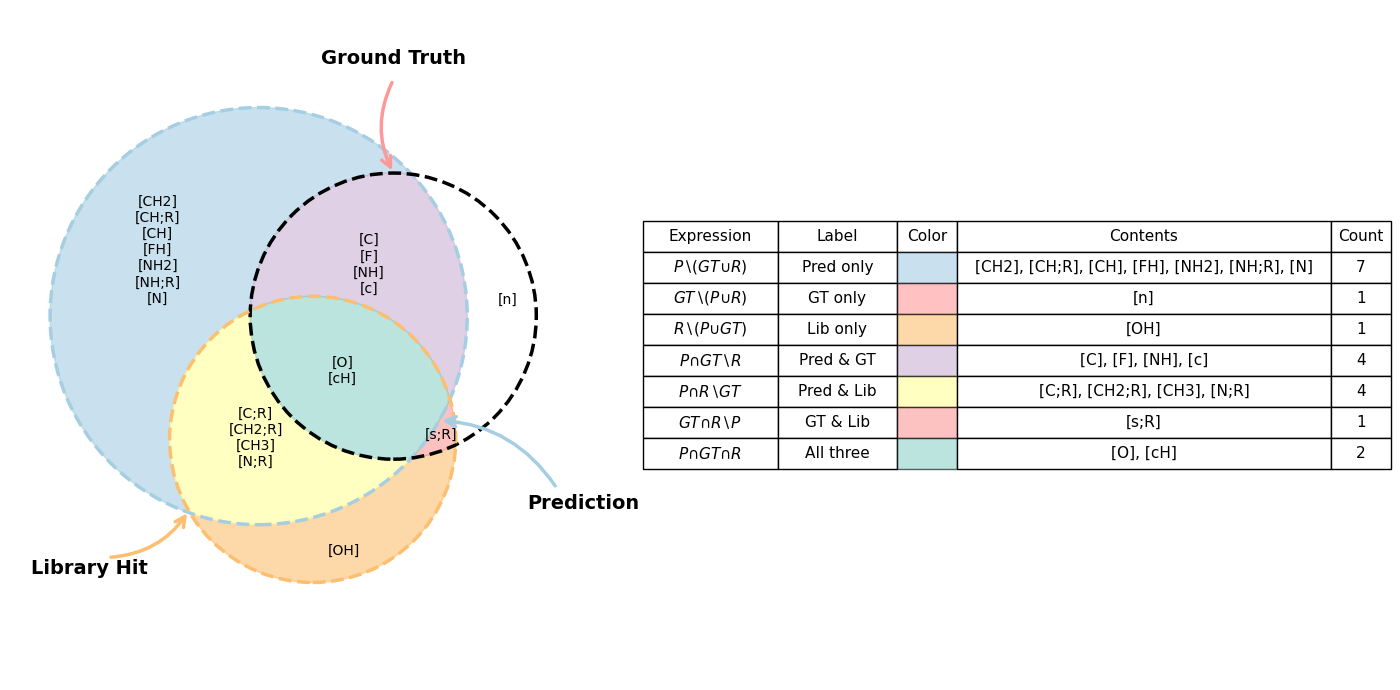

In [9]:
mapping_dict = {}  # Optional: fill with RAE mapping
with open("DBsearch.json") as f:
    results = json.load(f)

plot_venn_from_results(results, mapping_dict, idx=6817, topk=0, show_gt=True)


### Normalized (confidence) score of predicted content

In [10]:
def plot_sketch_style_bars_final(pred_all_rAEs_count):
    """
    Draw a downward bar plot for rAE probabilities, matching a UI-inspired style.
    """
    # Compute proportions for bar heights
    total = sum(pred_all_rAEs_count.values())
    labels = list(pred_all_rAEs_count.keys())
    proportions = [v / total for v in pred_all_rAEs_count.values()]
    counts = list(pred_all_rAEs_count.values())

    # Locate where count==1 begins
    one_indices = [i for i, v in enumerate(counts) if v == 1]
    first_one_idx = one_indices[0] if one_indices else len(labels)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.bar(
        range(len(labels)), proportions,
        color='#2196f3', edgecolor='black', linewidth=1.5, zorder=3
    )

    # Axis customization
    ax.axhline(0, color='black', linewidth=1)
    ax.invert_yaxis()
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    # Add counts above each bar
    offset = 0.08
    for idx, count in enumerate(counts):
        height = proportions[idx]
        ax.text(
            idx, height + offset, str(count),
            ha='center', va='bottom', fontsize=14, fontweight='normal'
        )

    # X/Y labels
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, fontsize=13, fontweight='bold')
    ax.set_xlabel('Structural content (rAEs)', labelpad=18, fontsize=13, fontweight='normal')
    ax.set_ylabel('Normalized score', fontsize=13, fontweight='normal')

    # Add vertical dashed line separating count==1
    if first_one_idx < len(labels):
        ax.axvline(x=first_one_idx - 0.5, linestyle='--', color='black', linewidth=1.5, zorder=2)

    # Grid and frame cleanup
    ax.grid(axis='y', linestyle=':', linewidth=1, alpha=0.4, zorder=0)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_position(('outward', 5))
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_visible(False)

    # Enforce downward bars
    ax.set_ylim(1, 0)

    plt.tight_layout()
    output_path = "score.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Saved figure to {output_path}")
    plt.show()


In [11]:
pred_all_rAEs_count= {'[C]': 9,
   '[F]': 7,
   '[CH]': 3,
   '[FH]': 1,
   '[c]': 8,
   '[CH2]': 2,
   '[cH]': 6,
   '[O]': 8,
   '[N;R]': 1,
   '[NH;R]': 1,
   '[CH;R]': 2,
   '[NH]': 3,
   '[NH2]': 2,
   '[CH3]': 1,
   '[C;R]': 1,
   '[N]': 1,
   '[CH2;R]': 1}

In [12]:
sorted_dict = dict(sorted(pred_all_rAEs_count.items(), key=lambda item: item[1], reverse=True))

Saved figure to score.png


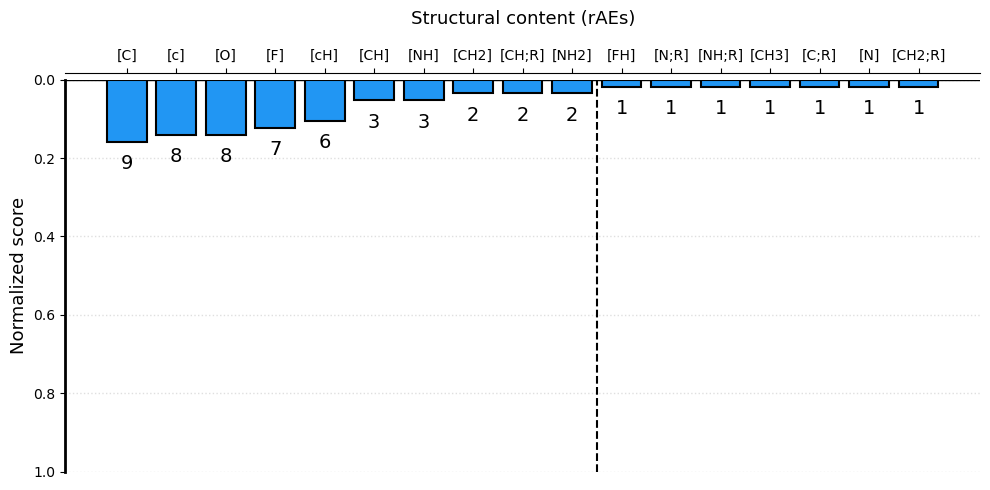

In [13]:
plot_sketch_style_bars_final(sorted_dict)